# Model Development in Impact Evaluation

## Background

A high school in PA implements a behavorial program to reduce energy usage. We want to estiamte this reduction during the year following the start of the program by modeling the pre-period consumption and using this model to predict counterfactual usage during the post-period. We estiamte the average program savigns by applyign this method across all participating schools. 

### Step 1: Importing Libraries and Data
The three main libraries we'll use are pandas, numpy, and sklearn. These all come standard with an installation of Anaconda. The data we use is stored in the repository and contains the following fields:

- Energy: daily energy consumption measured in kWh
- RH: average daily relative humidity
- Class: indicator variable, 1 when the school is in session and 0 otherwise
- Day: day of the week, 0-6 starting with Monday
- CDD: cooling degree days base 70
- HDD: heating degree days base 65

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import RepeatedKFold, GridSearchCV
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestRegressor
import warnings
warnings.filterwarnings("ignore")

In [2]:
school = 'Whitehall High School'
pre = pd.read_hdf('..\\data\\pa\\pre\\' + school + '.h5')
post = pd.read_hdf('..\\data\\pa\\post\\' + school + '.h5')

In [3]:
pre.head()

Energy         RH  Class  Day  CDD        HDD
2016-02-08 00:00:00-05:00  8325.53  56.708333    1.0    0  0.0  30.958333
2016-02-09 00:00:00-05:00  7840.24  82.000000    1.0    1  0.0  37.000000
2016-02-10 00:00:00-05:00  7983.36  66.041667    1.0    2  0.0  37.583333
2016-02-11 00:00:00-05:00  8365.11  53.666667    1.0    3  0.0  47.541667
2016-02-12 00:00:00-05:00  5521.67  56.375000    0.0    4  0.0  50.125000

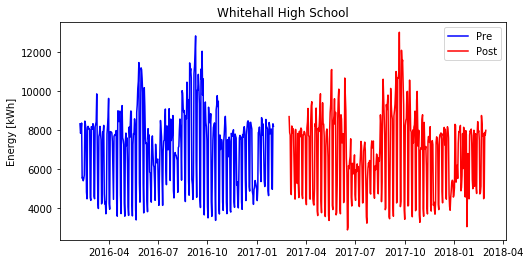

In [4]:
plt.close('all')
fig = plt.figure(figsize=(8, 4))
plt.plot(pre.index, pre.Energy, color='b', label='Pre')
plt.plot(post.index, post.Energy, color='r', label='Post')
plt.ylabel('Energy [kWh]')
plt.title(school)
plt.legend()

### Step 2: Feature Selection
We have a small feature set to work with, but stil want to identify those that are most important. We begin by seperateing the pre-period data into sepearte variables for the response (Energy, stored as y) and the candidate inputs (HDD, CDD, RH, Class, and Day, stored as X). Using sklearn's recursive feature elimination method we cross validate a randon forest regression model to identify features that do not imporve out of sample prediction. 

In [5]:
y = pre.iloc[:, 0].values
X = pre.iloc[:, 1:].values
model = RandomForestRegressor()
rfecv = RFECV(
    estimator=model, step=1,
    cv=RepeatedKFold(n_splits=2, n_repeats=200, random_state=True),
    scoring='neg_mean_squared_error')
rfecv.fit(X, y)

RFECV(cv=<sklearn.model_selection._split.RepeatedKFold object at 0x000001F6EB1906A0>,
   estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
   min_features_to_select=1, n_jobs=None, scoring='neg_mean_squared_error',
   step=1, verbose=0)

In [6]:
inputs = list()
for column_label in pre.columns.tolist()[1:]:
    if (rfecv.ranking_[
        pre.columns.tolist()[1:].index(column_label)] == 1):
        inputs.append(column_label)

In [7]:
inputs

['RH', 'Class', 'Day', 'CDD', 'HDD']

### Step 3: Hyperparameter Optimization
There are several hyperparamters that can be optimized, but in this example we'll only look at the minimum sample size for each leaf in the ensample of decision trees. Limiting the leaf size helps to prevent over fitting but it set too high models will underpreform. 

In [8]:
for column_label in pre.columns:
    if (column_label not in inputs) and (column_label != 'Energy'):
        del pre[column_label]
y = pre.iloc[:, 0].values
X = pre.iloc[:, 1:].values
model = RandomForestRegressor()
grid = GridSearchCV(
    estimator=model,
    param_grid={'min_samples_leaf': np.arange(1, 10, 1)},
    cv=RepeatedKFold(n_splits=2, n_repeats=50, random_state=True),
    scoring='neg_mean_squared_error')
grid.fit(X, y)
samples = grid.best_estimator_.min_samples_leaf

In [9]:
samples

3

### Step 4: Model Fit and Prediction
Once we've identified our optimal feature set and hyperparameters we fit the model and use it to predict counterfactual consuption during the post period.

In [10]:
model = RandomForestRegressor(min_samples_leaf=samples)
y_pre = pre.iloc[:, 0].values
X_pre = pre.iloc[:, 1:].values
model.fit(X_pre, y_pre)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=3, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [11]:
for column_label in post.columns:
    if (column_label not in inputs) and (column_label != 'Energy'):
        del post[column_label]
y_post = post.iloc[:, 0].values
X_post = post.iloc[:, 1:].values
y_post_hat = model.predict(X_post)

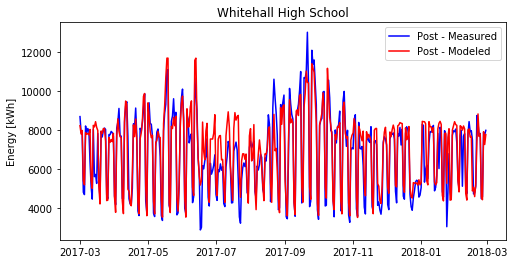

In [12]:
plt.close('all')
fig = plt.figure(figsize=(8, 4))
plt.plot(post.index, post.Energy, color='b', label='Post - Measured')
plt.plot(post.index, y_post_hat, color='r', label='Post - Modeled')
plt.ylabel('Energy [kWh]')
plt.title(school)
plt.legend()

In [13]:
pct_savings = (sum(y_post_hat) - sum(y_post)) / sum(y_post) * 100.
pct_savings

3.5438713053756987

In [14]:
df = pd.DataFrame()
df['y'] = y_post
df['y_hat'] = y_post_hat
df.index = post.index
gb = df.groupby(df.index.weekday).mean()

In [15]:
gb.plot(); plt.show()